In [1]:
import Interpolations, Plots, Random, Ipopt, Statistics, GLPK
using ColorTypes, StatsBase, Measures
using LaTeXStrings
using NumericalIntegration, JuMP, GLPK, Plots, Random, Interpolations, Statistics, LinearAlgebra, Distributions

In [2]:
global const ΔT            = 8e-6 # units: seconds\n",
global const GaussPerTesla = 10000.0;
global const FOV           = 10.0                             # units: centimeters\n",
global const ΔK            = 1/FOV                            # units: radians / centimeters\n",
global const γ             = 4258.0                           # units: Hz / Gauss\n",
global const α             = 1 / (γ * FOV)
global const c             = 334/1e6                          # units: seconds\n",
global const rng           = Random.MersenneTwister(1)
global const G_max         = 5.0                              # units: Gauss/cm, equivalent to 50mT/m\n",
global const S_max         = 20000.0                          # units: Gauss/cm/s, equivalent to 200T/m/s\n",
global const S_min         = 7027.0                           # units: Gauss/millimeters/seconds\n",

global const PNS_max       = 80.0                             # percent of peripheral nerve stimulation"

80.0

In [139]:
function generate_distance_matrix(n , Δ)
    Z = [ [n1+Δ,n2+Δ] for n1 = 1:n, n2 = 1:n]
    Z = reduce(hcat,Z)
    ℓ = size(Z,2)
    X = Z[1,:] .+ rand.(Uniform(-0.5,0.5),ℓ,1)[:]
    Y = Z[2,:] .+ rand.(Uniform(-0.5,0.5),ℓ,1)[:]
    δy= mean(Y)
    δx= mean(X)
    X = X .- δx
    Y = Y .- δy
    X = round.(X,digits=1)
    Y = round.(Y,digits=1)
    D = [sqrt((X[i] - X[j])^2 + (Y[i] - Y[j])^2) for i in 1:ℓ, j in 1:ℓ]
    return X[:], Y[:], D[:,:]
end
# HELPER FUNCTION FOR FINDING A PATH GIVEN UNDIRECTED GRAPH VERTEX MATRIX
function find_path_tsp(xs)
    E   = selected_edges(xs, size(xs, 1))
    # find path\n",
    ES  = similar(E)
    idx = 1
    e_0 = E[1][2]
    i_0 = 1
    e_0 = E[i_0][2]
    ES[1] = E[i_0]
    while idx < length(E) - 1
        cnds  = findall([e_0 ∈ e for e ∈ E])
        tmp_c = E[cnds]
        tmp_e = reduce(vcat,[collect(e) for e ∈ ES[1:idx]])
        tmp_i = any(reshape([ i ∉ tmp_e for j ∈ tmp_c for i ∈ j],2,2)',dims=2)[:]
        nxt_e = tmp_c[tmp_i][1]
        idx   = idx + 1
        nxt_e = collect(nxt_e)
        tmp_e = (nxt_e[nxt_e .== e_0][1], nxt_e[nxt_e .!== e_0][1])
        ES[idx] = tmp_e
        e_0   = [e for e ∈ nxt_e if e != e_0][1]

    end
    # last one\n",
    nxt_e = ES[end-1]
    e_0   = nxt_e[2]
    cnds  = findall([e_0 ∈ e for e ∈ E])
    tmp_c = E[cnds]
    ES[end] = [e for e ∈ tmp_c if e != nxt_e][1]
    ES[end] = (ES[end-1][2],ES[1][1])
    return ES
end


function find_path(xs)
    E   = selected_edges(xs, size(xs, 1))
    # find path
    ES  = similar(E)
    idx = 1
    e_0 = E[1][2]
    i_0 = 1
    e_0 = E[i_0][2]
    ES[1] = E[i_0]
    while idx < length(E) 
        cnds  = findall([e_0 ∈ e for e ∈ E])
        tmp_c = E[cnds]
        tmp_e = reduce(vcat,[collect(e) for e ∈ ES[1:idx]])
        tmp_m = [ i ∉ tmp_e for j ∈ tmp_c for i ∈ j];
        num_m = Int64(floor(length(tmp_m)/2));
        tmp_i = any(reshape(tmp_m,2,num_m)',dims=2)[:]
        #tmp_i = any(reshape(tmp_m,2,2)',dims=2)[:]
        if !any(tmp_i) #path to nowhere, delete nodes
            deleteat!(E,idx)
            deleteat!(E,idx)
            deleteat!(ES,idx)
            deleteat!(ES,idx)
            e_0 = E[1][2]
            ES[1]= E[1]
        else
            nxt_e = tmp_c[tmp_i][1]
            #idx   = idx + 1
            nxt_e = collect(nxt_e)
            tmp_e = (nxt_e[nxt_e .== e_0][1], nxt_e[nxt_e .!== e_0][1])
            ES[idx] = tmp_e
            e_0   = [e for e ∈ nxt_e if e != e_0][1]
        end
        idx = idx + 1
    end
    # last one
    nxt_e = ES[end-1]
    e_0   = nxt_e[2]
    cnds  = findall([e_0 ∈ e for e ∈ E])
    tmp_c = E[cnds]
    lst_e = [e for e ∈ tmp_c if e != nxt_e]
    if !isempty(lst_e) #path to nowhere
        ES[end] = [e for e ∈ tmp_c if e != nxt_e][1]
    else
        pop!(ES)
        pop!(ES)
    end
    gn   = findall([e[1] > n .|| e[2] > n for e in ES])
    deleteat!(ES,gn[:])
    return ES
end


function make_triangular(A)
    n = size(A,1)
    for i in 1:n
        for j in i:n
            A[i,j] = 0.0
        end
    end
    return A
end
# FUNCTIONS FOR SOLVING TRAVELING SALESMAN PROBLEM
function build_tsp_model(d, n)
    model = Model(GLPK.Optimizer)
    @variable(model, x[1:n, 1:n], Bin, Symmetric)
    @objective(model, Min, sum(d .* x) )
    @constraint(model, [i in 1:n], sum(x[i, :]) == 2)
    @constraint(model, [i in 1:n], x[i, i] == 0)
    return model
end
# helper function for finding dubtours
function subtour(edges::Vector{Tuple{Int,Int}}, n)
    shortest_subtour, unvisited = collect(1:n), Set(collect(1:n))
    while !isempty(unvisited)
        this_cycle, neighbors = Int[], unvisited
        while !isempty(neighbors)
            current = pop!(neighbors)
            push!(this_cycle, current)
            if length(this_cycle) > 1
                pop!(unvisited, current)
            end
            neighbors =
                [j for (i, j) in edges if i == current && j in unvisited]
        end
        if length(this_cycle) < length(shortest_subtour)
            shortest_subtour = this_cycle
        end
    end
    return shortest_subtour
end
function selected_edges(x::Matrix{Float64}, n)
    n = size(x,1)
    return Tuple{Int,Int}[(i, j) for i in 1:n, j in 1:n if x[i, j] > 0.0]
end
subtour(x::Matrix{Float64}) = subtour(selected_edges(x, size(x, 1)), size(x, 1))
subtour(x::AbstractMatrix{VariableRef}) = subtour(value.(x))

function get_tsp_path(d,n)

    # find a good start path
    iterative_model = build_tsp_model(d, n);
    optimize!(iterative_model);
    global time_iterated = solve_time(iterative_model)
    global cycle = subtour(iterative_model[:x])
    while 1 < length(cycle) < n
        #println(\Found cycle of length $(length(cycle))\)
        S = [(i, j) for (i, j) in Iterators.product(cycle, cycle) if i < j]
        @constraint(
            iterative_model,
            sum(iterative_model[:x][i, j] for (i, j) in S) <= length(cycle) - 1,
        )
        optimize!(iterative_model)
        global time_iterated += solve_time(iterative_model)
        global cycle = subtour(iterative_model[:x])
    end

    objective_value(iterative_model)
    A=value.(iterative_model[:x])
    A=make_triangular(A)
    return A
end
            
            
# FUNCTIONS FOR COMPUTING k-space trajectory, gradients and slew rates in x and y direction
function get_kspace_trajectory_path_interpolate(xs,ux,uy,d,z=false)
    if z
        ES = find_path(xs)
    else
        ES   = find_path_tsp(xs)
    end
    n    = length(ES)
    D    = sum(d .* xs)         # D mm
    NK   = Int64(round(D/ΔK))   # number of samples to have spatial resolution equal to ΔK
    Tint = LinRange(ΔT, ΔT*NK, n)
    Xn   = ux[:]
    Yn   = uy[:]
    Kx   = [Xn[e[1]] for e ∈ ES]
    Ky   = [Yn[e[1]] for e ∈ ES]
    push!(Kx, ux[ES[end][2]])
    push!(Ky, uy[ES[end][2]])
    NQ   = length(Kx);          # number of nodes visited in graph
    Tund = LinRange(Tint[1],Tint[end],NQ)
    Kxs  = CubicSplineInterpolation(Tund,Kx,extrapolation_bc = Line())
    Kys  = CubicSplineInterpolation(Tund,Ky,extrapolation_bc = Line())
    return Kxs, Kys, Tund
end

function get_grad_pns_path_interpolate(Kx, Ky, t)
# Inputs: Kx: function that approximates K-space in x direction
#         Ky: function that approximates K-space in y direction
#         t:  time vector for evaluation Kx and Ky
#         i.e. t = LinRange(t₀, tₙ, N)
# outputs: PNS, gradient and slew rate
    t  = LinRange(t[1],t[end], 800)
    DT = t[2]-t[1]
    Kxs= Kx(t)
    Kys= Ky(t)
    Gx = α.* diff(Kxs)/DT;
    Gy = α.* diff(Kys)/DT

    Sx = diff(Gx)/ΔT
    Sy = diff(Gy)/ΔT
    Gx = [0.0 ; Gx[:]] # zero pad
    Gy = [0.0 ; Gy[:]]
                
    Sx = [0.0 ; 0.0; Sx[:]]
    Sy = [0.0 ; 0.0; Sy[:]]

    fxt = (c .* Sx *ΔT) ./ (c .+ t[end]*ΔT .- t*ΔT) .^2
    fyt = (c .* Sy *ΔT) ./ (c .+ t[end]*ΔT .- t*ΔT) .^2

    Rxt = cumsum(fxt[:]) .* 1/S_min
    Ryt = cumsum(fyt[:]) .* 1/S_min

    PNS = sqrt.(Rxt.^2 .+ Ryt.^2) .*100

    G   = sqrt.(Gx.^2 .+ Gy.^2)
    S   = sqrt.(Sx.^2 .+ Sy.^2 )
    return PNS[:], G[:], S[:], t[:], Gx, Gy, Sx, Sy
end
# FUNCTION FOR GENERATING NEW COLUMNS
function generate_columns(Π,Λ,d,ΔTMS,d_max)
    n = size(d,1)
    b = zeros(1,n)
    b[1]   = 1.0
    b[end] = -1.0
    dmodel = Model(GLPK.Optimizer)
    @variable(dmodel, x[1:n,1:n], Bin)
    @objective(dmodel, Min, sum((ΔTMS*d .- (Π.* d*ΔTMS)).*x) - Λ)
    @constraint(dmodel, [i = 1:n], x[i,i]== 0);
    @constraint(dmodel, [i = 1:n], sum(x[i, :]) - sum(x[:, i]) == b[i])
    @constraint(dmodel, sum(x) >= d_max)
    optimize!(dmodel);
    #Kxs,Kys, Tund = get_kspace_trajectory_path_interpolate(value.(dmodel[:x]),X,Y,d, true)
    #PNS,Gn,Sn,Tn,Gxn,Gyn = get_grad_pns_path_interpolate(Kxs, Kys, Tund)
    # to-do: need to have a PNS matrix where PNS is computed for all possible paths 
    #@objective(dmodel, Min, sum((ΔTMS*d .+ sum(PNS) .- (Π.* d*ΔTMS)).*x) - Λ)

    display(objective_value(dmodel))
    if objective_value(dmodel) < 0
        return value.(dmodel[:x])
    end
    return nothing
end

generate_columns (generic function with 1 method)

In [4]:
# Generate paths
q = 10
n = q^2
m = 50
Δ = 5.0 #nodes are 5cm apart
X,Y,d = generate_distance_matrix(q,Δ)
A     = get_tsp_path(d,n);
Kx,Ky, Tund = get_kspace_trajectory_path_interpolate(A,X,Y,d);
PNS,G,S,T,Gx,Gy,Sx,Sy = get_grad_pns_path_interpolate(Kx, Ky, Tund);

In [130]:
K = 200; # paths to generate
𝐀 = Array{Any}(nothing, K+1) 
𝐗 = Array{Any}(nothing, K+1)
𝐘 = Array{Any}(nothing, K+1)
𝐆 = Array{Any}(nothing, K+1)
𝐒 = Array{Any}(nothing, K+1)
𝐏 = Array{Any}(nothing, K+1)
𝐃 = Array{Any}(nothing, K+1)
𝐆x= Array{Any}(nothing, K+1)
𝐆y= Array{Any}(nothing, K+1)
𝐒x= Array{Any}(nothing, K+1)
𝐒y= Array{Any}(nothing, K+1)
𝐓n= Array{Any}(nothing, K+1)
𝐊x= Array{Any}(nothing, K+1)
𝐊y= Array{Any}(nothing, K+1)
idx = 1
while idx < K+1
    idxs   = sample(1:n,m,replace=false)
    Xn    = X[idxs]
    Yn    = Y[idxs]
    dn    = [sqrt((Xn[i] - Xn[j])^2 + (Yn[i] - Yn[j])^2) for i in 1:m, j in 1:m]
    An    = deepcopy(get_tsp_path(dn,m))
    An    = deepcopy(make_triangular(An))
    Kxs,Kys, Tund = get_kspace_trajectory_path_interpolate(An,Xn,Yn,dn)
    PNSn,Gn,Sn,Tn,Gxn,Gyn,Sxn,Syn = get_grad_pns_path_interpolate(Kxs, Kys, Tund)
    cnd    = all((PNSn .<= PNS_max) .&& (Gn .<= G_max) .&& (Sn .<= S_max)) .&& (sum(An) .== m)

    if cnd
        𝐃[idx] = dn
        𝐏[idx] = PNSn
        𝐆[idx] = Gn
        𝐒[idx] = Sn
        𝐀[idx] = An
        𝐗[idx] = Xn
        𝐘[idx] = Yn
        𝐆x[idx]= Gxn
        𝐆y[idx]= Gyn
        𝐒x[idx]= Sxn
        𝐒y[idx]= Syn
        𝐓n[idx]= Tn
        𝐊x[idx]= Kxs(Tn)
        𝐊y[idx]= Kys(Tn)
        idx = idx + 1
    end
    
end
𝐃[K+1] = d
𝐏[K+1] = PNS
𝐆[K+1] = G
𝐒[K+1] = S
𝐀[K+1] = A
𝐗[K+1] = X
𝐘[K+1] = Y;
𝐆x[K+1]= Gx;
𝐆y[K+1]= Gy;
𝐒x[K+1]= Sx;
𝐒y[K+1]= Sy;
𝐓n[K+1]= T;
𝐊x[K+1]= Kx(T)
𝐊y[K+1]= Ky(T);

In [174]:
path_lengths= [sum(𝐃[p].*𝐀[p]) for p = 1:N_p]
max_length = maximum(path_lengths)

86.96669278044952

In [267]:
sum(𝐃[1].*𝐀[1])/max_length

0.6808286532242115

In [270]:
mean(𝐏[1])/100

0.1481026141327401

In [275]:
# PATH BASED FORMULATION:
# FINDS PATH THAT TRAVERSES K-SPACE IN LOWEST AMOUNT OF TIME AMONGST PATHS
# Generates new path via column generation and accepts path if it leads to a reduced cost
# returns best path, otherwise
N_p = K+1;
path_lengths = [sum(𝐃[i].*𝐀[i]) for i = 1:N_p]

D_MAX = mean(path_lengths)#sum(A.*d)/3
ΔTMS  = ΔT.*1000 #time in milliseconds
N_p   = K+1
M = Model(GLPK.Optimizer)
@variable(M, λ[1:N_p] >= 0.0)
𝛌 = @constraint(M, sum(λ) == 1.0)
𝛑 = @constraint(M, sum(sum(𝐃[p].*𝐀[p])*λ[p] for p =1:N_p) >= D_MAX); #subject to path constraints
@objective(M,Min,sum(( (0.5*sum(𝐃[p].*𝐀[p])/max_length) + 0.5*mean(𝐏[p]./100))*λ[p] for p=1:N_p) ); #find path that traverses k-space in shortest time
optimize!(M);
# while true 
#     optimize!(M);
#     display(N_p)
#     Π = dual.(𝛑)
#     Λ = dual.(𝛌)
#     idxs=(value.(M[:λ]).>0) .* LinRange(1,N_p,N_p)
#     #display(idxs[idxs .> 0])
#     #display([Π,Λ]')
#     b_idx = argmax(value.(M[:λ]))
#     d_max = sum(𝐀[b_idx])
#     new_path = generate_columns(Π,Λ,d,ΔTMS,d_max);
#     # new path found
#     # need to compute pns
#     if isnothing(new_path)
#         break
#     else
#         Kxs,Kys, Tund = get_kspace_trajectory_path_interpolate(new_path,X,Y,d,true)
#         PNS,Gn,Sn,Tn,Gxn,Gyn = get_grad_pns_path_interpolate(Kxs, Kys, Tund)
#         push!(𝐃,d)
#         push!(𝐏, PNS[:])
#         push!(𝐆,Gn[:])
#         push!(𝐒,Sn[:])
#         push!(𝐆x,Gxn[:])
#         push!(𝐆y,Gyn[:])
#         push!(𝐓n,Tn[:])
#         push!(𝐀, new_path)
#         push!(λ, @variable(M, lower_bound=0.0, upper_bound=1.0,base_name = "λ[$(N_p+1)]"))
            
#     end
#     N_p = deepcopy(N_p + 1); 
#     display(size(𝐀))
#     display(size(𝐃))
#     𝛑 = @constraint(M, sum(sum(𝐀[p].*𝐃[p])*λ[p] for p =1:N_p) >= D_MAX)

# end

In [276]:
# # set default plot properties
default(
    linewidth=2, 
    framestyle=:box, 
    grid=false,
    ytickfontsize=:18,
    xtickfontsize=:18,
    titlefontsize=:18,
    xlabelfontsize=:18,
    ylabelfontsize=:18, 
    legendfontsize=:18,
    rotation=:45,
    foreground_color_legend = nothing,
    background_color_legend = nothing,
)

In [277]:
using LaTeXStrings

In [278]:
# waveform plot
best_sol = argmin(value.(M[:λ]))
T_best   = 𝐓n[best_sol]
T_best   = T_best*1000;


G_best   = 𝐆[best_sol]
Gx_best  = 𝐆x[best_sol]
Gy_best  = 𝐆y[best_sol]
S_best   = 𝐒[best_sol]
Sx_best  = 𝐒x[best_sol]
Sy_best  = 𝐒y[best_sol]
PNS_best = 𝐏[best_sol]
Kx_best  = 𝐊x[best_sol]
Ky_best  = 𝐊y[best_sol]


wvfplt = plot(T_best,G_best,color=:red2,label=:"|G|"); 

plot!(T_best,Gx_best,color=:antiquewhite4,label= L"G_x"); 
plot!(T_best,Gy_best,color=:salmon,label= L"G_y",legend=:outertop); 
title!("Gradient waveform"); hline!([G_max],color=:red,label=:none)
xlabel!("time (milliseconds)")
ylabel!("G/cm")


srsplt = plot(T_best,S_best,color=:teal,yformatter =:scientific, label=:"|S|"); 

plot!(T_best,Sx_best,color=:lightcyan3,yformatter =:scientific,label= L"S_x"); 
plot!(T_best,Sy_best,color=:gold2,yformatter =:scientific,label= L"S_y",legend=:outertop,link=:x,size=(400,300)); 
title!("Slew rate"); hline!([S_max],color=:teal,label=:none)
xlabel!("time (milliseconds)")
ylabel!("G/cm/s")

# pns plot
pnsplt = plot(T_best,PNS_best,color=:black,legend=:outertop,label=:"",link=:x,size=(400,300)); 

title!("Peripheral nerve stimulation"); hline!([PNS_max],color=:grey,label=:none)
xlabel!("time (milliseconds)")
ylabel!("%")
pn2plt = plot(wvfplt,srsplt,pnsplt,layout=(3,1),size=(600,1400), margin = 15mm,link=:x)
savefig(pn2plt,"path_p_2.svg")

In [279]:
# plot 1: k-space graph
PathTraversalPlot = Plots.plot()
for k = 1:K
    Ek = find_path_tsp(𝐀[k])
    # plot edge order: they are not in order

    Xn = 𝐗[k]*0.01
    Yn = 𝐘[k]*0.01
    idx = 1
    for (i, j) in Ek

        plot!([Xn[i], Xn[j]], [Yn[i], Yn[j]]; legend = false,color = RGB(rand(3)...),linewidth=:2,alpha=:0.2)
        ux = sum([Xn[i], Xn[j]])/2 -.2
        uy = sum([Yn[i], Yn[j]])/2 
        #annotate!(ux,uy, text(idx, :black, :center, 8))
        idx = idx + 1
    end


end
b_idx = argmin(value.(M[:λ]))
EE = find_path_tsp(make_triangular(𝐀[b_idx]))
# plot edge order: they are not in order

Xn = 𝐗[b_idx]*0.01
Yn = 𝐘[b_idx]*0.01
idx = 1
for (i, j) in EE

    plot!([Xn[i], Xn[j]], [Yn[i], Yn[j]]; legend = false, color =:red,linewidth=:8,alpha=:0.8,linestyle=:dashdotdot)
    ux = sum([Xn[i], Xn[j]])/2 
    uy = sum([Yn[i], Yn[j]])/2 
    annotate!(ux,uy, text(idx, :black, :center, 14))

     idx = idx + 1
end
#plot!(Kx_best*0.01, Ky_best*0.01, color=:red2,linewidth=:8,alpha=:8,size=(900,900),linestyle=:dot)
scatter!(X*0.01,Y*0.01,color=:black,markersize=:4,size=(900,900)); #ylims!(0,5); xlims!(0,5)
xlabel!(L"$K_x (1/m)")
ylabel!(L"$K_y (1/m)")
title!("K-space paths")
plot(PathTraversalPlot,margin = 5mm,size=(900,900));
savefig(PathTraversalPlot,"path_traversal_plot.svg")
#scatter!([X[1]],[Y[1]],markersize=:10,color=:red)
#scatter!([X[end]],[Y[end]],markersize=:10,color=:blue)

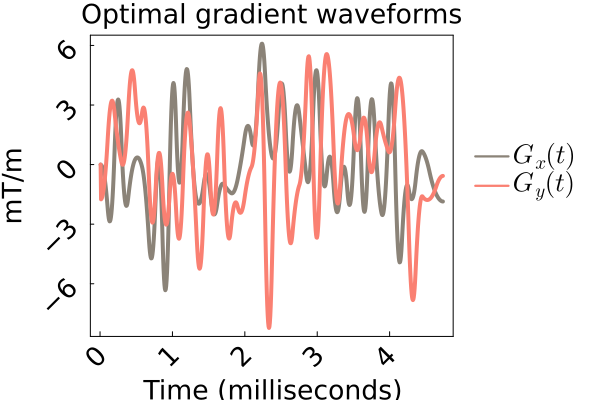

In [280]:
g_plot=plot(T_best,Gx_best.*(0.1/0.01),color=:antiquewhite4,label= L"G_x(t)",linewidth=:4)
plot!(T_best,Gy_best.*(0.1/0.01),color=:salmon,label= L"G_y(t)",legend=:outerright,linewidth=:4)
ylabel!("mT/m")
xlabel!("Time (milliseconds)")
title!("Optimal gradient waveforms")

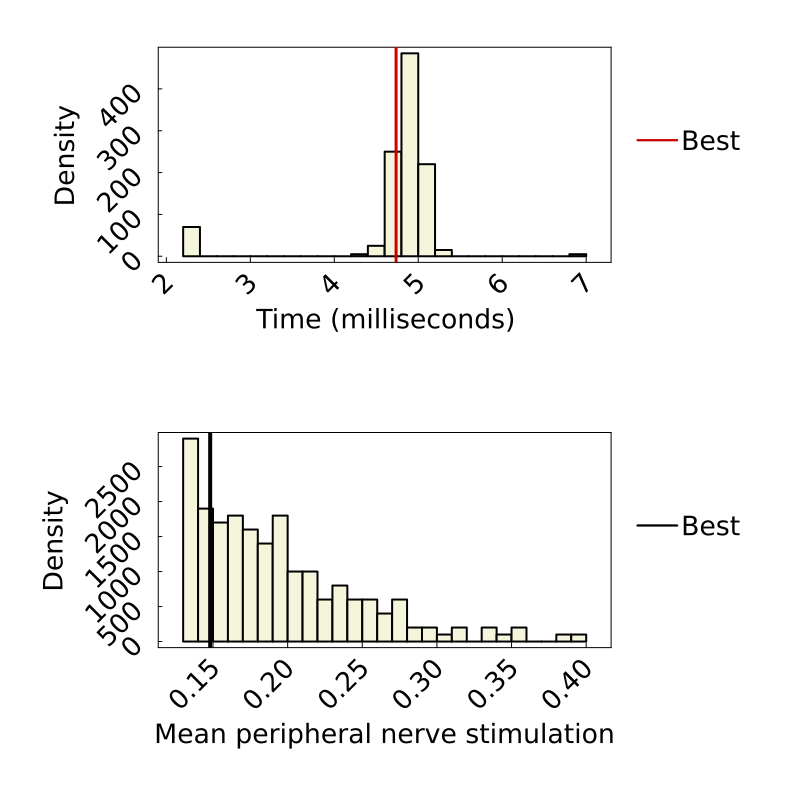

In [250]:
all_times = [t[end] for t ∈ 𝐓n].*1000
#d1 = histogram(path_lengths[:].*0.01,normalize=:density,label=:none,color=:beige,bins=30); 
#vline!([path_lengths[best_sol].*0.01],color=:red3,linewidth=:5,label=:"Best",legend=:outerright)
#xlabel!("Path length (m)")
d1 = histogram(all_times[:],normalize=:density,label=:none,color=:beige,bins=30)
vline!([all_times[best_sol]],color=:red3,linewidth=:3,label=:"Best",legend=:outerright)
ylabel!("Density")
xlabel!("Time (milliseconds)")
all_pns = [mean(𝐏[i]/100) for i = 1:N_p]
d2= histogram(all_pns,normalize=:density,color=:beige,label=:none,bins=30)
vline!([all_pns[best_sol]],linewidth=:4,color=:black,label=:"Best",legend=:outerright); 
xlabel!("Mean peripheral nerve stimulation")
ylabel!("Density")

d3=plot(d1,d2,layout=(2,1),size=(800,800),margin=10mm)

In [266]:
sum(ΔT.*cumsum(ΔT.*𝐆[best_sol].^2))/(0.01^2)

0.0254652271544137

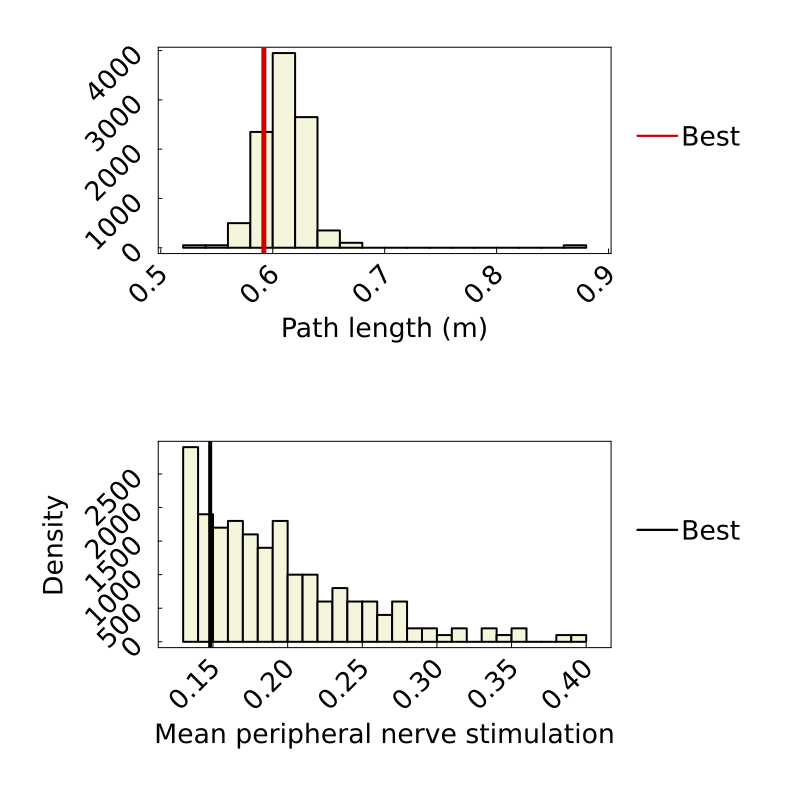

In [248]:
all_times = [t[end] for t ∈ 𝐓n].*1000
d1 = histogram(path_lengths[:].*0.01,normalize=:density,label=:none,color=:beige,bins=30); 
vline!([path_lengths[best_sol].*0.01],color=:red3,linewidth=:5,label=:"Best",legend=:outerright)
xlabel!("Path length (m)")

all_pns = [mean(𝐏[i]/100) for i = 1:N_p]
d2= histogram(all_pns,normalize=:density,color=:beige,label=:none,bins=30)
vline!([all_pns[best_sol]],linewidth=:4,color=:black,label=:"Best",legend=:outerright); 
xlabel!("Mean peripheral nerve stimulation")
ylabel!("Density")

d3=plot(d1,d2,layout=(2,1),size=(800,800),margin=10mm)


In [281]:
f3=plot(g_plot,d1,d2,layout=(3,1),size=(800,800))
savefig(f3,"comparison.svg")
savefig(g_plot,"gradients.svg")

In [282]:
t_max = maximum([t[end]*1000 for t ∈ 𝐓n])
t_best = 𝐓n[best_sol][end]*1000
(t_best-t_max)/t_max*100

-31.95402298850575

In [208]:
display(D_MAX*0.01)

0.6112951618678195